# Project

In [1]:
from collections import Counter
# from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import mord
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import plot_regress_exog

In [2]:
path = 'review-Alaska_10.json'

data_raw = pd.read_json(path, lines=True, encoding='utf-8')

C:\Users\wtyyx\anaconda3\Lib\site-packages\pandas\core\dtypes\astype.py:189: RuntimeWarning: invalid value encountered in cast
  return values.astype(dtype, copy=copy)


This indicates the presence of NA values in the data. However, as this is one of the aspects we intend to investigate, we will selectively perform data cleaning at a later stage.

In [3]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  521515 non-null  float64
 1   name     521515 non-null  object 
 2   time     521515 non-null  int64  
 3   rating   521515 non-null  int64  
 4   text     298257 non-null  object 
 5   pics     20851 non-null   object 
 6   resp     44232 non-null   object 
 7   gmap_id  521515 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.8+ MB
None


In [4]:
print(data_raw.head())

        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b6

## Data Dictionary

- index: The index of the data.
- user_id: The ID of the reviewer.
- name: The name of the reviewer.
- time: The time of the review in Unix time format.
- rating: The rating given by the reviewer for the business.
- text: The text of the review.
- pics: Pictures associated with the review.
- resp: The business response to the review, including Unix time and the text of the response.
- gmap_id: The ID of the business.

Due to the nature of our research topic, which is to explore the influence of time of day on online ratings across different devices, we will be selecting specific data variables for further analysis. The data variables of interest include "time," "rating," and "pics." The reason for selecting "pics" is due to the unfortunate inability to obtain data directly related to device types in the comments. Therefore, we need to make a crucial assumption: 
**we assume that comments with pictures are uploaded using mobile devices, while comments without pictures are uploaded using non-mobile devices.**

## Data Preprocessing



In this section, we will perform data preprocessing, which includes data cleaning and data transformation. Data cleaning involves handling missing values, outliers, and inconsistencies in the dataset. Data transformation may involve converting the "pics" data into device type data, etc. These steps allow us to make use of the available information and derive meaningful insights from the dataset. 

In [5]:
# Label encoding and one-hot encoding
data_modified = (
    data_raw
    .assign(time=lambda x: pd.to_datetime(x['time'], unit='ms').dt.hour)
    # time[1,2,3] represents ['Morning', 'Noon', 'Evening']
    .assign(time=lambda x: pd.cut(x['time'], bins=[0, 8, 16, 24], labels=[1,2,3], right=False))
    # device[0,1] represents ['Non-mobile device', 'Mobile devices']
    .assign(device=lambda x: x['pics'].notnull().astype(int))
    .filter(['time', 'rating', 'device'])
)

print(data_modified[:10])


  time  rating  device
0    3       5       0
1    1       5       0
2    1       4       0
3    3       4       0
4    1       5       0
5    2       5       0
6    1       5       1
7    1       4       0
8    1       2       0
9    3       3       0


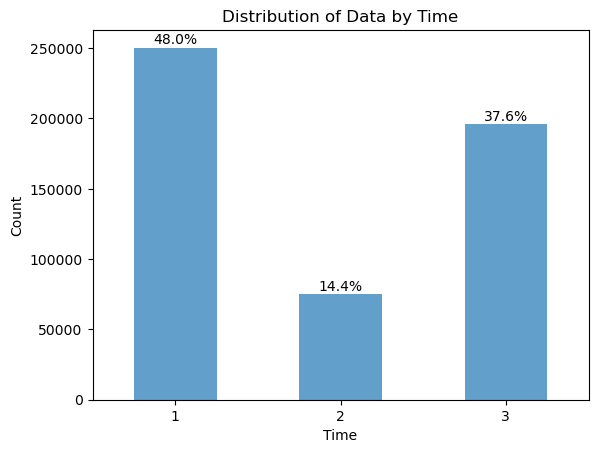

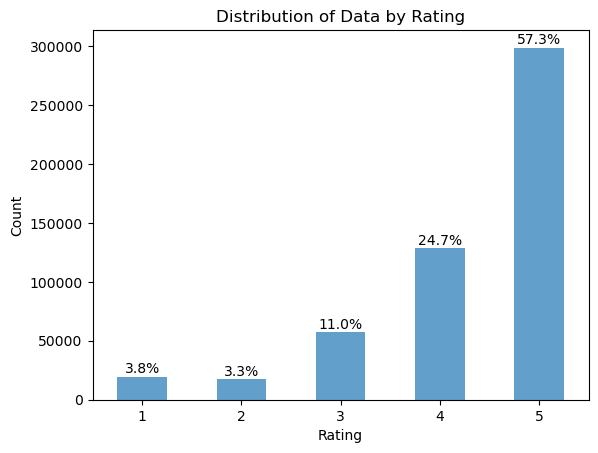

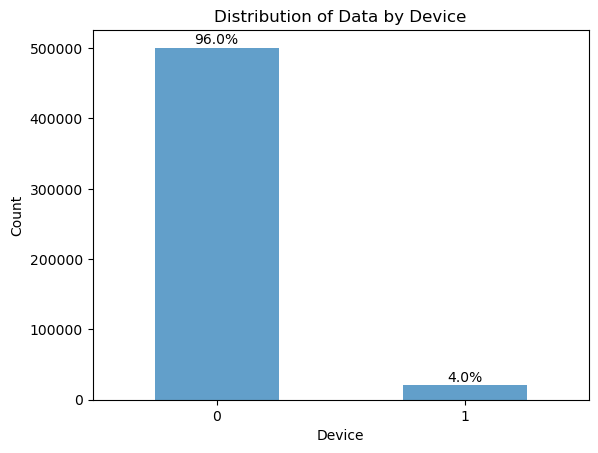

In [6]:
# Histogram for data distribution by time
counts = data_modified['time'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Data by Time')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

# Histogram for data distribution by rating
counts = data_modified['rating'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

# Histogram for data distribution by devices
counts = data_modified['device'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Device')
plt.ylabel('Count')
plt.title('Distribution of Data by Device')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

In [7]:
print(data_modified.isnull().sum())

time      0
rating    0
device    0
dtype: int64


### Chi-square

In [8]:
# Chi-square test for 'time' and 'device'
chi2_time_device, p_time_device, dof_time_device, expected_time_device = stats.chi2_contingency(pd.crosstab(data_modified['time'], data_modified['device']))
print("Chi-square test result for 'time' and 'device':")
print("Chi-square statistic:", chi2_time_device)
print("P-value:", p_time_device)

Chi-square test result for 'time' and 'device':
Chi-square statistic: 77.89168097553406
P-value: 1.2190917242198965e-17


In [9]:
# Chi-square test for 'rating' and 'device'
chi2_rating_device, p_rating_device, dof_rating_device, expected_rating_device = stats.chi2_contingency(pd.crosstab(data_modified['rating'], data_modified['device']))
print("\nChi-square test result for 'rating' and 'device':")
print("Chi-square statistic:", chi2_rating_device)
print("P-value:", p_rating_device)


Chi-square test result for 'rating' and 'device':
Chi-square statistic: 2611.3884589742765
P-value: 0.0


In [10]:
# Chi-square test for 'rating' and 'time'
chi2_rating_time, p_rating_time, dof_rating_time, expected_rating_time = stats.chi2_contingency(pd.crosstab(data_modified['rating'], data_modified['time']))
print("\nChi-square test result for 'rating' and 'time':")
print("Chi-square statistic:", chi2_rating_time)
print("P-value:", p_rating_time)


Chi-square test result for 'rating' and 'time':
Chi-square statistic: 470.5512843830127
P-value: 1.4561827422400162e-96


The results of the chi-square test indicate that there is some degree of correlation between all three variables.

### Correlation Matrix

In [11]:
data_modified['time'] = data_modified['time'].astype(int)
corr_matrix = data_modified.corr()

print(corr_matrix)


            time    rating    device
time    1.000000  0.005652  0.002651
rating  0.005652  1.000000  0.064005
device  0.002651  0.064005  1.000000


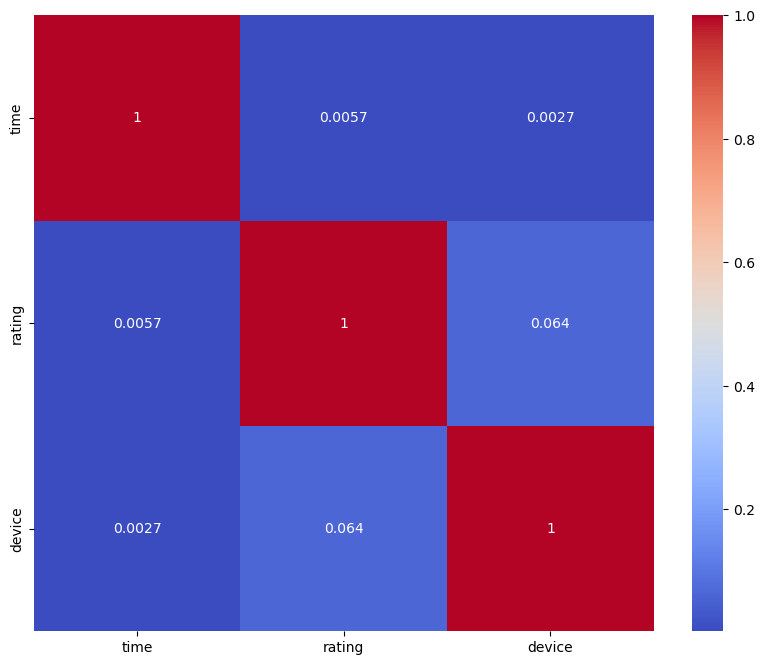

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


### Multicollinearity test

In [13]:
X = data_modified[['time', 'rating', 'device']]
vif_data = pd.DataFrame()
vif_data['Features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nMulticollinearity test:")
print(vif_data)


Multicollinearity test:
  Features       VIF
0     time  4.272621
1   rating  4.321498
2   device  1.045736


The Variance Inflation Factors (VIF) for the 'time', 'rating', and 'device' variables are 4.27, 4.32, and 1.05 respectively. Typically, a VIF value greater than 5 or 10 indicates high multicollinearity. Here, none of the VIF values exceed these thresholds, suggesting that multicollinearity is not a significant concern in this dataset.

Summary: In the data processing phase of this project, we first cleaned and transformed the data appropriately. We then performed exploratory data analysis to visualize the distribution of ratings across different times of day and devices. Next, we conducted chi-square tests which revealed significant associations between 'time', 'device', and 'rating'. Correlation Matrix then proved these associations are not linear. A Variance Inflation Factor (VIF) test confirmed that multicollinearity was not a significant concern. This prepared the data effectively for the subsequent modeling phase.

## Modeling

### Train and Test Sets

In [14]:
# Separate features (X) and target variable (y) in the balanced dataset
X = data_modified.drop('rating', axis=1)
y = data_modified['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2221877)


### Data Balancing

It can be seen that there is a significant data imbalance between the different ratings. Having tried sampling and undersampling, I ended up combining them to try and get the most optimal sampling results to support my models.

In [15]:
# Calculate the number of samples in each class
counter = Counter(y)

# Define the target sample numbers for over-sampling and under-sampling
max_samples = max(counter.values())
min_samples = min(counter.values())

# Define pipeline
over = SMOTE(sampling_strategy={class_label: max_samples for class_label in counter})
under = RandomUnderSampler(sampling_strategy={class_label: min_samples for class_label in counter})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Sample numbers before resampling: Counter({5: 298638, 4: 128640, 3: 57407, 1: 19591, 2: 17239})
Sample numbers after resampling: Counter({1: 17239, 2: 17239, 3: 17239, 4: 17239, 5: 17239})


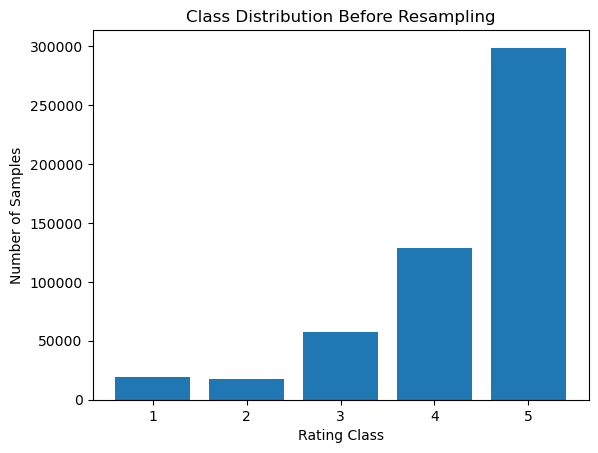

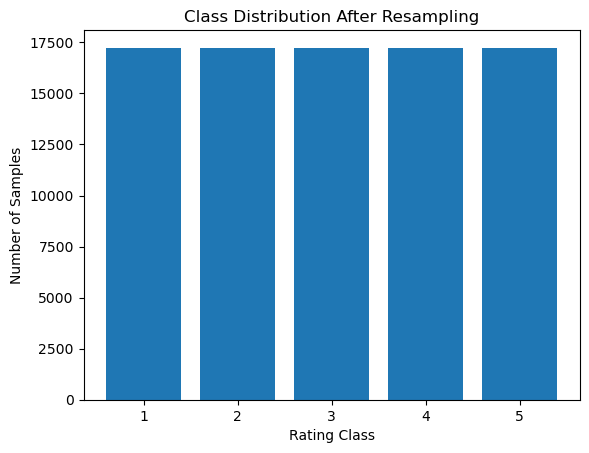

In [16]:
# Calculate the number of samples in each class before resampling
print("Sample numbers before resampling:", counter)

# Calculate the number of samples in each class after resampling
counter_after = Counter(y_resampled)
print("Sample numbers after resampling:", counter_after)

# Visualize class distribution before resampling
plt.bar(counter.keys(), counter.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Resampling')
plt.show()

# Visualize class distribution after resampling
plt.bar(counter_after.keys(), counter_after.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Resampling')
plt.show()


In [17]:
# Description of 'time' for each 'rating'
print(data_modified.groupby('rating')['time'].describe())

# Description of 'device' for each 'rating'
print(data_modified.groupby('rating')['device'].describe())


           count      mean       std  min  25%  50%  75%  max
rating                                                       
1        19591.0  1.903323  0.918832  1.0  1.0  2.0  3.0  3.0
2        17239.0  1.883752  0.911027  1.0  1.0  2.0  3.0  3.0
3        57407.0  1.882959  0.905324  1.0  1.0  2.0  3.0  3.0
4       128640.0  1.886762  0.915916  1.0  1.0  2.0  3.0  3.0
5       298638.0  1.903000  0.924071  1.0  1.0  2.0  3.0  3.0
           count      mean       std  min  25%  50%  75%  max
rating                                                       
1        19591.0  0.017151  0.129836  0.0  0.0  0.0  0.0  1.0
2        17239.0  0.019723  0.139050  0.0  0.0  0.0  0.0  1.0
3        57407.0  0.017507  0.131150  0.0  0.0  0.0  0.0  1.0
4       128640.0  0.029447  0.169055  0.0  0.0  0.0  0.0  1.0
5       298638.0  0.051507  0.221030  0.0  0.0  0.0  0.0  1.0


In [18]:
# # # Separate features (X) and target variable (y)
# # X = data_modified.drop('rating', axis=1)
# # y = data_modified['rating']

# # Apply SMOTEENN using training sets
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# # # Create a new balanced dataframe
# # balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
# # balanced_data['rating'] = y_resampled

# # # Check the balanced distribution of ratings
# # print(balanced_data['rating'].value_counts())

# # Check the balanced distribution of ratings
# print(pd.Series(y_resampled).value_counts())


In [19]:
# from imblearn.combine import SMOTETomek

# # Separate features (X) and target variable (y)
# X = data_modified.drop('rating', axis=1)
# y = data_modified['rating']

# # Apply SMOTETomek
# smote_tomek = SMOTETomek(random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# # Create a new balanced dataframe
# balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
# balanced_data['rating'] = y_resampled

# # Check the balanced distribution of ratings
# print(balanced_data['rating'].value_counts())


### Decision Tree

Default parameter:

Accuracy score:  0.2165055442683487
              precision    recall  f1-score   support

           1       0.21      0.39      0.28      3404
           2       0.20      0.47      0.28      3472
           3       0.22      0.17      0.19      3434
           4       0.00      0.00      0.00      3520
           5       0.39      0.05      0.09      3409

    accuracy                           0.22     17239
   macro avg       0.21      0.22      0.17     17239
weighted avg       0.20      0.22      0.17     17239



C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


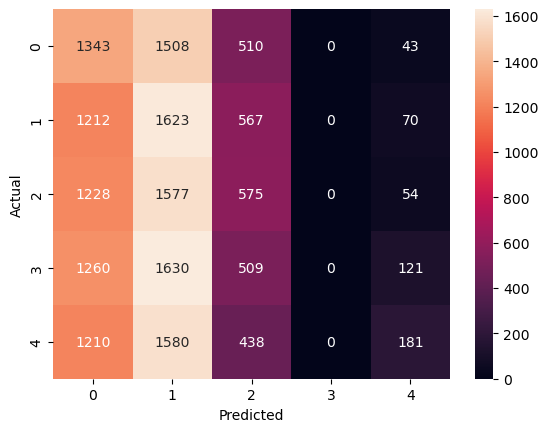

In [20]:
model = DecisionTreeClassifier()

model.fit(X_resampled, y_resampled)

predictions = model.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Grid search:

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy score:  0.2165055442683487
              precision    recall  f1-score   support

           1       0.21      0.39      0.28      3404
           2       0.20      0.47      0.28      3472
           3       0.22      0.17      0.19      3434
           4       0.00      0.00      0.00      3520
           5       0.39      0.05      0.09      3409

    accuracy                           0.22     17239
   macro avg       0.21      0.22      0.17     17239
weighted avg       0.20      0.22      0.17     17239



C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


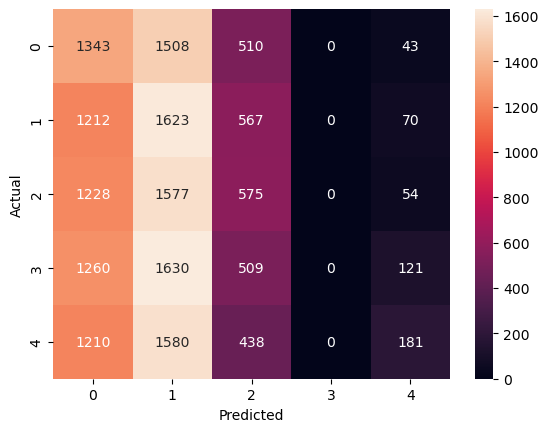

In [21]:
# Define the parameter grid to search
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50]
}

model = DecisionTreeClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object to the resampled data
grid_search.fit(X_resampled, y_resampled)

print(grid_search.best_params_)

# Get the best parameters
best_param = grid_search.best_estimator_

# Use the best model to make predictions
predictions = best_param.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Random Forest

Default parameter:

Accuracy score:  0.2165055442683487
              precision    recall  f1-score   support

           1       0.21      0.39      0.28      3404
           2       0.20      0.47      0.28      3472
           3       0.22      0.17      0.19      3434
           4       0.00      0.00      0.00      3520
           5       0.39      0.05      0.09      3409

    accuracy                           0.22     17239
   macro avg       0.21      0.22      0.17     17239
weighted avg       0.20      0.22      0.17     17239



C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


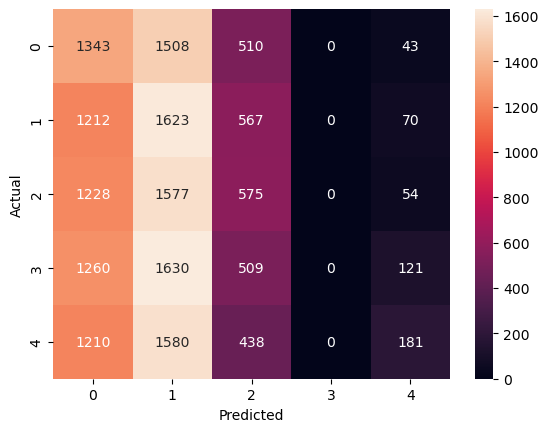

In [22]:
model = RandomForestClassifier()

model.fit(X_resampled, y_resampled)

predictions = model.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Grid search:

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy score:  0.2165055442683487
              precision    recall  f1-score   support

           1       0.21      0.39      0.28      3404
           2       0.20      0.47      0.28      3472
           3       0.22      0.17      0.19      3434
           4       0.00      0.00      0.00      3520
           5       0.39      0.05      0.09      3409

    accuracy                           0.22     17239
   macro avg       0.21      0.22      0.17     17239
weighted avg       0.20      0.22      0.17     17239



C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


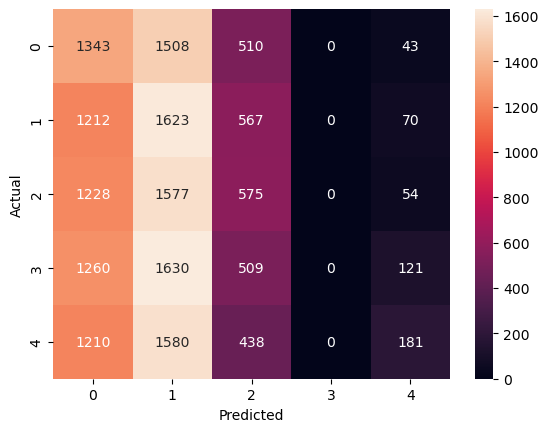

In [23]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create the Random Forest classifier
model = RandomForestClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the resampled data
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Ordinal Logistic Regression

Accuracy score:  0.20372997961560863
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3404
           2       0.00      0.00      0.00      3472
           3       0.20      0.98      0.33      3434
           4       0.26      0.03      0.06      3520
           5       0.00      0.00      0.00      3409

    accuracy                           0.20     17239
   macro avg       0.09      0.20      0.08     17239
weighted avg       0.09      0.20      0.08     17239



C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wtyyx\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


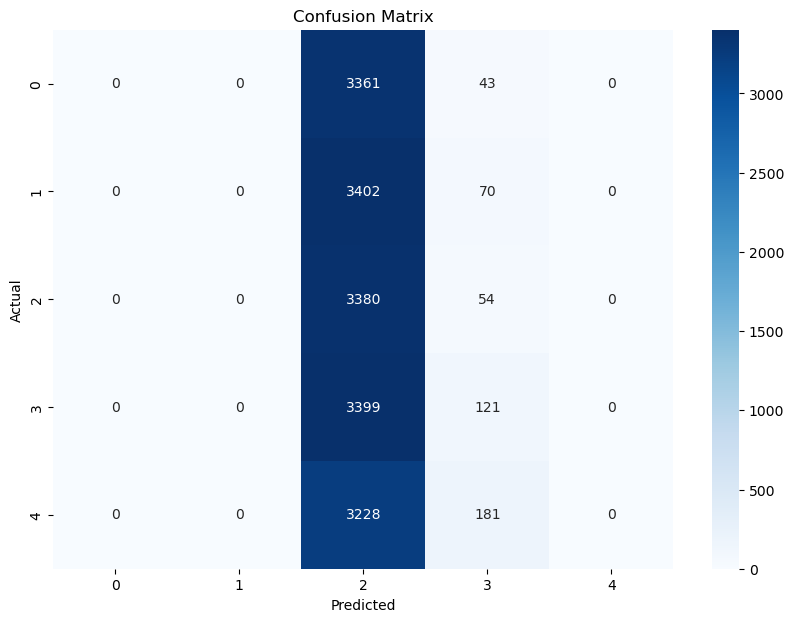

In [24]:
# Create an instance of the LogisticAT model
model = mord.LogisticAT()

# Fit the model to the data
model.fit(X_resampled, y_resampled)

# Use the model to make predictions
predictions = model.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Gradient Boosting 

In [ ]:
# Define the parameter grid
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7, 9],
}

# Create a GradientBoostingClassifier
model = GradientBoostingClassifier()

# Initialize a GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy', error_score='raise')

# Fit the GridSearchCV object to the data
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters
best_params = grid_search.best_params_

# Use the best model to make predictions
model = GradientBoostingClassifier(
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
)

# Fit the model and make predictions
model.fit(X_resampled, y_resampled)
predictions = model.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Model Comparisons
